In [13]:
# Import Library

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims


from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

In [15]:
import os
from openvino.runtime import Core
import torch

# Verify and set the model path
model_path = "best_model.path"
if not os.path.exists(model_path):
    print(f"File not found: {model_path}")
else:
    print("File found!")

    # Initialize OpenVINO and load the model
    core = Core()
    try:
        model = core.read_model(model_path)
        compiled_model = core.compile_model(model, "GPU")  # Using Intel GPU
        print("Model successfully loaded and compiled on Intel GPU.")
    except Exception as e:
        print(f"Error loading model: {e}")

# Check for CUDA availability and print GPU details
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu_count = torch.cuda.device_count()

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print("CUDA-enabled GPU detected:", gpu_name)
else:
    print("No CUDA-enabled GPU detected")

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())
print(f"Using device: {device}")


File not found: best_model.path
No CUDA-enabled GPU detected
Using 0 GPUs
CUDA is available: False
Using device: cpu


In [16]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# Data Preparation

In [17]:
import os

In [18]:
# define folder path for each set
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model

In [19]:

# Ensure your device is set correctly for CPU or CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

# Move the model to the device (CPU)
model.to(device)
print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=1, bias=True)
  (14): Sigmoid()
)


# Loop

In [20]:
# hyperparameter

lr = 0.001
weight_decay = 0.0001
epochs = 20
optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='max')
criterion = nn.BCELoss()

# save checkpoint
save = 'model'

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_acc = 0.0
output_list = []

# Training loop


def train_one_epoch(model, device, criterion, optimizer, train_loader):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    for batch in train_loader:
        data, labels = batch
        data, labels = data.to(device), labels.to(device).float()  # Convert labels to float
        labels = labels.view(-1, 1)  # Reshape labels to match predictions
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.round()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    end_time = time.time()
    train_loss /= len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc, end_time - start_time

def val_one_epoch(model, device, criterion, val_loader, best_acc, save=False):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    with torch.no_grad():
        for batch in val_loader:
            data, labels = batch
            data, labels = data.to(device), labels.to(device).float()  # Convert labels to float
            labels = labels.view(-1, 1)  # Reshape labels to match predictions
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    end_time = time.time()
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    if val_acc > best_acc and save:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    return val_loss, val_acc, end_time - start_time, best_acc


for epoch in range(epochs):
    train_loss, train_acc, train_time = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc = val_one_epoch(model, device, criterion, val_loader, best_acc, save=True)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)
    print(output_str)
    lr_scheduler.step(val_acc)

Epoch 1/20 - loss: 0.5711 - train_acc: 71.05% - val_loss: 0.5937 - val_acc: 68.75% - time: 75.11s
Epoch 2/20 - loss: 0.3922 - train_acc: 88.55% - val_loss: 0.5212 - val_acc: 87.50% - time: 55.26s
Epoch 3/20 - loss: 0.2641 - train_acc: 92.40% - val_loss: 0.4346 - val_acc: 93.75% - time: 60.40s
Epoch 4/20 - loss: 0.1927 - train_acc: 93.95% - val_loss: 0.3661 - val_acc: 87.50% - time: 59.76s
Epoch 5/20 - loss: 0.1573 - train_acc: 94.95% - val_loss: 1.1151 - val_acc: 50.00% - time: 56.48s
Epoch 6/20 - loss: 0.1296 - train_acc: 96.00% - val_loss: 0.4007 - val_acc: 81.25% - time: 51.27s
Epoch 7/20 - loss: 0.1122 - train_acc: 96.35% - val_loss: 0.8594 - val_acc: 62.50% - time: 55.42s
Epoch 8/20 - loss: 0.0952 - train_acc: 96.80% - val_loss: 0.7790 - val_acc: 56.25% - time: 55.60s
Epoch 9/20 - loss: 0.0981 - train_acc: 97.20% - val_loss: 0.4690 - val_acc: 75.00% - time: 68.78s
Epoch 10/20 - loss: 0.0894 - train_acc: 97.10% - val_loss: 0.1437 - val_acc: 93.75% - time: 57.36s
Epoch 11/20 - loss:

# Graph

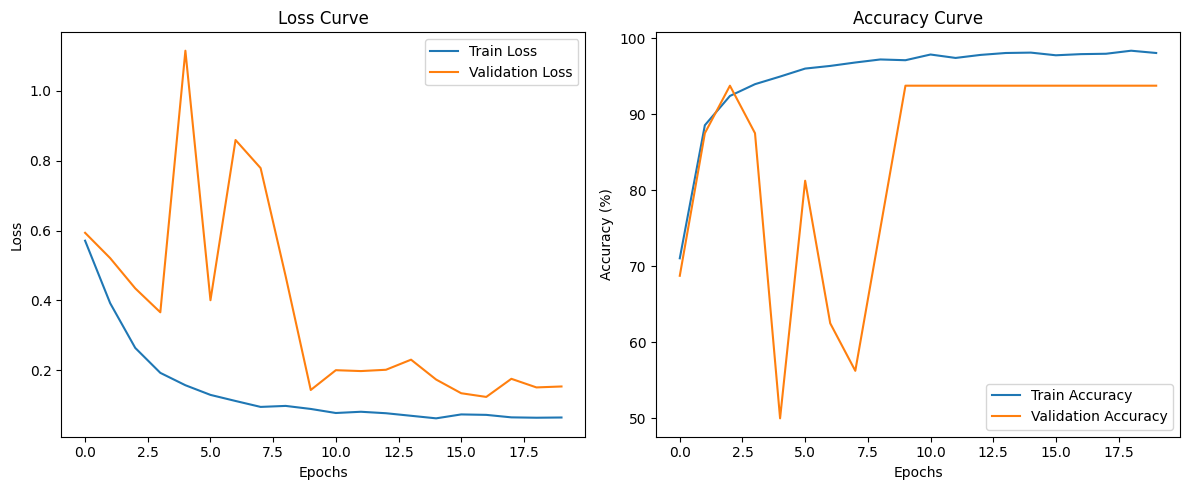

In [22]:
plt.figure(figsize=(12, 5))

# loss graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# show
plt.tight_layout()
plt.show()

# Evaluate

In [23]:
model_path = 'best_model.pth'
avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)
model.load_state_dict(torch.load(model_path, weights_only=True))


Model weights loaded successfully.
Test Accuracy: 84.74%
Test Loss: 0.3512


<All keys matched successfully>

#hyperparameter

In [24]:
import os
import torch
import torch.nn as nn
from openvino.runtime import Core

# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Define your model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Load your PyTorch model
model_path = "best_model.pth"
model = SimpleNN()

# Load the state dict and adjust keys
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
new_state_dict = {}
for key in state_dict.keys():
    new_key = key.replace('1.', 'model.1.').replace('2.', 'model.2.').replace('5.', 'model.5.').replace('6.', 'model.6.').replace('9.', 'model.9.').replace('10.', 'model.10.').replace('13.', 'model.13.')
    new_state_dict[new_key] = state_dict[key]

model.load_state_dict(new_state_dict)

# Convert the PyTorch model to ONNX format
dummy_input = torch.randn(1, 1, 256, 256)  # Adjust input size as required
onnx_model_path = "best_model.onnx"
torch.onnx.export(model, dummy_input, onnx_model_path)
print(f"ONNX model saved to {onnx_model_path}")

# Run Model Optimizer from terminal:
# mo --input_model best_model.onnx --output_dir . --model_name best_model

# Verify and set the OpenVINO model path
xml_model_path = "best_model.xml"
bin_model_path = "best_model.bin"

compiled_model = None  # Initialize the variable

if os.path.exists(xml_model_path) and os.path.exists(bin_model_path):
    print("Model files found!")
    
    # Initialize OpenVINO and load the model
    core = Core()
    try:
        compiled_model = core.compile_model(xml_model_path, "GPU")  # Using Intel GPU
        print("Model successfully loaded and compiled on Intel GPU.")
    except Exception as e:
        print(f"Error loading model: {e}")

# Check for CUDA availability and print GPU details
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpu_count = torch.cuda.device_count()

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Using GPU: {gpu_name} with {gpu_count} device(s) available.")
else:
    print("CUDA is not available. Running on CPU.")

# Prepare a sample input tensor for inference only if compiled_model is defined
if compiled_model is not None:
    try:
        # Prepare a sample input tensor for inference
        input_tensor = torch.randn(1, 1, 256, 256).numpy()  # Convert to NumPy for OpenVINO

        # Create an input blob for OpenVINO
        input_blob = compiled_model.input(0)
        output_blob = compiled_model.output(0)

        # Perform inference
        result = compiled_model([input_tensor])[output_blob]
        print("Inference completed. Output:", result)
    except Exception as e:
        print(f"Error during inference: {e}")
else:
    print("Compiled model is not defined. Skipping inference.")


ONNX model saved to best_model.onnx
CUDA is not available. Running on CPU.
Compiled model is not defined. Skipping inference.
